In [1]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [2]:
aqt_results = pd.read_csv("../data/AQT/QMarina-AQT-4Q.csv", index_col=0)
aqt_results = aqt_results.set_index(["Time", "Protocol", "Randomizations", "Identities"])

nox_data = aqt_results.xs("NOX", level="Protocol")
aqt_times = nox_data.index.get_level_values("Time").unique()

# renormalize in the 1-excitation subspace; average emitter 2 and 3
nox_data_norm = nox_data.copy()
nox_data_norm[['1000', '0100', '0010', '0001']] = nox_data_norm[['1000', '0100', '0010', '0001']].divide(nox_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
nox_data_norm['avg_0100_0001'] = nox_data_norm[['0100', '0001']].mean(axis=1)

aqt_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0001",
    "Cavity + Environment": "0010",
}

normed_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2 and 3": "avg_0100_0001",
    "Cavity + Environment": "0010",
}

In [3]:
rc_data = aqt_results.xs("RC", level="Protocol")

# renormalize in the 1-excitation subspace; average emitter 2 and 3
rc_data_norm = rc_data.copy()
rc_data_norm[['1000', '0100', '0010', '0001']] = rc_data_norm[['1000', '0100', '0010', '0001']].divide(rc_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
rc_data_norm['avg_0100_0001'] = rc_data_norm[['0100', '0001']].mean(axis=1)

rc_40 = rc_data_norm.xs(40, level="Randomizations")

1 0.10936532189814738
2 0.07861507731057131
3 0.08767875359251975
4 0.084594824558851
6 0.10626410310473283


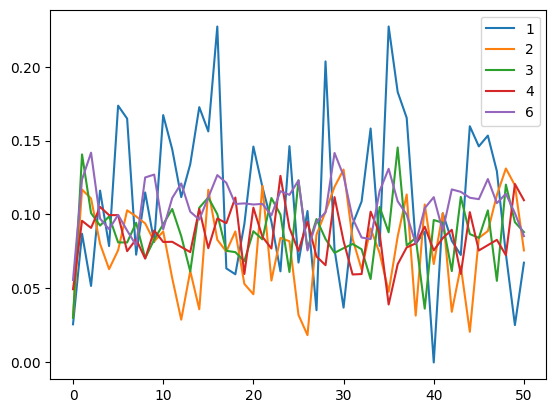

In [4]:
for n_id in [1,2,3,4,6]:
    data = nox_data.xs(n_id, level="Identities")
    data = 1 - data[['1000', '0100', '0010', '0001']].sum(axis=1)
    plt.plot(data.tolist(), label=n_id)
    print(n_id, data.mean())
plt.legend()

In [5]:
N = 3
g = 4
kappa = 2
times = np.linspace(0, 3, 51)

In [6]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

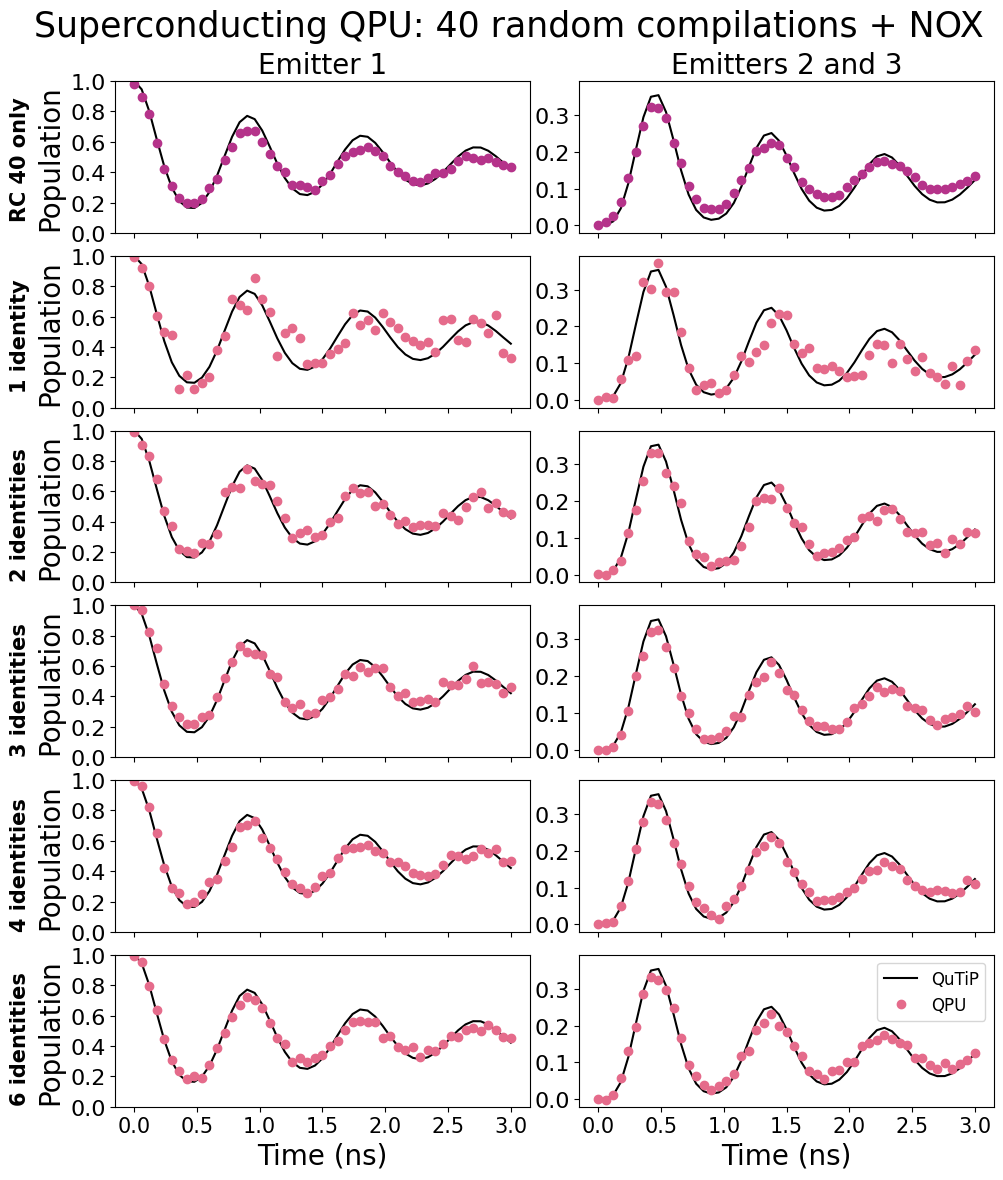

In [12]:
# Plot the RC + NOX data in a grid
fig, axes = plt.subplots(6, 2, figsize=(10, 12), sharex=True, sharey="col")

identities = [1, 2, 3, 4, 6]


axes[0][0].plot(times, qutip_results["Emitter 1"], label="QuTiP", color='black')
axes[0][0].plot(aqt_times, rc_40[normed_bitstrs["Emitter 1"]], marker='o', linestyle='', label="QPU", color='#b5338a')

axes[0][1].plot(times, qutip_results["Emitter 2"], label="QuTiP", color='black')
axes[0][1].plot(aqt_times, rc_40[normed_bitstrs["Emitter 2 and 3"]], marker='o', linestyle='', label="QPU", color='#b5338a')


for ax, num_id in zip(axes[1:, 0], identities):
    ax.plot(times, qutip_results["Emitter 1"], label="QuTiP", color='black')

    nox = nox_data_norm.xs(num_id, level="Identities")
    ax.plot(aqt_times, nox[normed_bitstrs["Emitter 1"]], marker='o', linestyle='', label="QPU", color="#e56b8b")
    

for ax, num_id in zip(axes[1:, 1], identities):
    ax.plot(times, qutip_results["Emitter 2"], label="QuTiP", color='black')

    nox = nox_data_norm.xs(num_id, level="Identities")
    ax.plot(aqt_times, nox[normed_bitstrs["Emitter 2 and 3"]], marker='o', linestyle='', label="QPU", color="#e56b8b")


for ax in axes.flatten():
    ax.tick_params(axis='y', labelsize=16)

for ax in axes[:, 0]:
    ax.set_ylabel("Population", fontsize=20)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

for ax in axes[:, 1]:
    ax.set_yticks([0, 0.1, 0.2, 0.3])


axes[-1][0].set_xlabel("Time (ns)", fontsize=20)
axes[-1][1].set_xlabel("Time (ns)", fontsize=20)
axes[-1][0].tick_params(axis="x", labelsize=15)
axes[-1][1].tick_params(axis="x", labelsize=15)


axes[0, 0].set_title("Emitter 1", fontsize=20)
axes[0, 1].set_title("Emitters 2 and 3", fontsize=20)


axes[0][0].text(-0.23, 0.9, "RC 40 only", transform=axes[0][0].transAxes, weight='bold',
        ha='center', va='top', fontsize=15, rotation=90)

for ax, num_id in zip(axes[1:, 0], identities):
    text = f"{num_id} identity" if num_id == 1 else f"{num_id} identities"
    vert = 0.85 if num_id == 1 else 0.89
    ax.text(-0.23, vert, text, transform=ax.transAxes, weight='bold',
            ha='center', va='top', fontsize=15, rotation=90)


fig.suptitle("Superconducting QPU: 40 random compilations + NOX", fontsize=25)

plt.tight_layout()
fig.subplots_adjust(top=0.92, hspace=0.05)

plt.legend(fontsize=12)

fig.subplots_adjust(hspace=0.15, wspace=0.12)

In [13]:
fig.savefig("../figures/AQT_RC_NOX.eps", bbox_inches="tight")

In [9]:
from errorbars import calculate_mae_uncertainty, write_results_to_file

for num_id in [1,2,3,4,6]:
    for part1, part2 in zip(["Emitter 1", "Emitter 2"], ["Emitter 1", "Emitter 2 and 3"]):
        nox = nox_data_norm.xs(num_id, level="Identities")
        exp = nox[normed_bitstrs[part2]]
        thy = qutip_results[part1]

        results = calculate_mae_uncertainty(exp, thy)
        write_results_to_file(results, processor="AQT", emitter=part1, condition=f"RC 40 + NOX {num_id}")